# Part 3: Obtaining and comparing predictions using the three models (BP, BP-F, MLR-F)
The first step is make all the necessary imports needed for the code:

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from NeuralNet import NeuralNet

#### MSE, MAE and MAPE
Then we make a function to calculate all the different metrics needed in this section. In this case, the metrics are:
- MSE - Mean Squared Error
- MAE - Mean Absolute Error
- MAPE - Mean Absolute Percentage Error

In [27]:
def compute_metrics(y_true, y_pred):
    """
    Compute MSE, MAE, and MAPE using scikit-learn.
    Returns the three metrics as floats.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # convert to %
    
    return mse, mae, mape

#### Denormalize function
The denormalize function is called each time the model generates predictions, ensuring that the predicted values are stored in their denormalized form. When creating plots, this function is also applied to the real values to maintain consistency. 

In [28]:
def denormalize(arr_scaled, col='SalePrice'):
    """
    Inverse transform matching normalization:
    scaled = 0.1 + 0.8 * (orig - abs_min) / (abs_max - abs_min)
    so inverse: orig = abs_min + (scaled - 0.1)/0.8 * (abs_max - abs_min)
    """
    mn, mx = min_max[col]
    arr_scaled = np.asarray(arr_scaled).ravel()
    return mn + (arr_scaled - 0.1) / 0.8 * (mx - mn)

#### Load data and normalization
To process the data, it is first loaded from the CSV file and normalized using the min-max method. After normalization, the dataset is split into two subsets: 80% for training and 20% for testing. This section also defines the various hyperparameters, some of which use regularization and dropout techniques. Finally, the results_list is created to store the best results obtained by the different models.

In [29]:
# Load the data from the dataset
df = pd.read_csv('data_clean.csv')
df = df.select_dtypes(include = ['float64', 'int64'])

#store the min and the max of each column to denormalize the data later
min_max = {}
for column in df.columns:
    min_max[column] = [df[column].abs().min(), df[column].abs().max()]

# normalize all the data of the dataframe between 0 and 1
df_scaled = df.copy()

#normalize the data between 0 and 1 using the min_max dictionary
for column in df_scaled.columns:
    df_scaled[column] = 0.1 + 0.8 * (df_scaled[column] - min_max[column][0]) / (min_max[column][1] - min_max[column][0])

y = df_scaled['SalePrice'].values
X = df_scaled.drop('SalePrice', axis=1).values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definition of hyperparameters including L2 regularization and dropout
hyperparams = [
    # Baseline Models (No Regularization)
    {'layers':[X_train.shape[1], 8, 1], 'activation':'relu',
     'lr':0.01, 'momentum':0.0, 'epochs':150,
     'weight_decay':0.0, 'dropout_rate':0.0},

    {'layers':[X_train.shape[1], 8, 1], 'activation':'tanh',
     'lr':0.01, 'momentum':0.9, 'epochs':200,
     'weight_decay':0.0, 'dropout_rate':0.0},

    {'layers':[X_train.shape[1], 16, 8, 1], 'activation':'relu',
     'lr':0.005, 'momentum':0.8, 'epochs':250,
     'weight_decay':0.0, 'dropout_rate':0.0},

    # L2 Regularization
    {'layers':[X_train.shape[1], 16, 1], 'activation':'sigmoid',
     'lr':0.01, 'momentum':0.8, 'epochs':200,
     'weight_decay':0.0005, 'dropout_rate':0.0},   # Mild L2

    {'layers':[X_train.shape[1], 32, 16, 1], 'activation':'relu',
     'lr':0.001, 'momentum':0.9, 'epochs':300,
     'weight_decay':0.001, 'dropout_rate':0.0},    # Medium L2

    {'layers':[X_train.shape[1], 4, 1], 'activation':'tanh',
     'lr':0.02, 'momentum':0.0, 'epochs':150,
     'weight_decay':0.01, 'dropout_rate':0.0},     # High L2

    # Dropout
    {'layers':[X_train.shape[1], 10, 5, 1], 'activation':'relu',
     'lr':0.01, 'momentum':0.8, 'epochs':200,
     'weight_decay':0.0, 'dropout_rate':0.1},      # Light dropout

    {'layers':[X_train.shape[1], 20, 10, 1], 'activation':'tanh',
     'lr':0.005, 'momentum':0.7, 'epochs':250,
     'weight_decay':0.0, 'dropout_rate':0.3},      # Moderate dropout

    {'layers':[X_train.shape[1], 12, 1], 'activation':'relu',
     'lr':0.02, 'momentum':0.9, 'epochs':180,
     'weight_decay':0.0, 'dropout_rate':0.5},      # Strong dropout

    # Combined Regularization (Dropout + L2 Regularization)
    {'layers':[X_train.shape[1], 6, 3, 1], 'activation':'tanh',
     'lr':0.001, 'momentum':0.6, 'epochs':300,
     'weight_decay':0.001, 'dropout_rate':0.2},
]

results_list = []

#### Custom BP Model
The custom BP model is trained using the previously defined hyperparameters. For each hyperparameter set, a NeuralNet instance is created with the parameters provided by the for loop. After training, the model generates predictions and the metrics MSE, MAE, and MAPE are computed, along with the final loss values. All results for every hyperparameter configuration are stored in the custom_results list. The results_list stores only the best prediction, corresponding to the configuration with the lowest MSE.

In [30]:
# Custom BP
custom_results = []         # store ALL hyperparameter results
best_mse_bp = np.inf        # track best result
best_metrics_bp = None      # store the best

for params in hyperparams:
    nn_model = NeuralNet(layers = params['layers'], epochs = params['epochs'], learning_rate = params['lr'], momentum = params['momentum'],
        function = params['activation'],
        validation_split = 0.2
    )

    # Train the model
    nn_model.fit(X_train, y_train)
    pred_train_bp_scaled = nn_model.predict(X_train)
    pred_test_bp_scaled  = nn_model.predict(X_test)

    # Denormalize the data obtained
    pred_train_bp = denormalize(pred_train_bp_scaled.flatten(), 'SalePrice')
    pred_test_bp = denormalize(pred_test_bp_scaled.flatten(), 'SalePrice')
    y_train_den = denormalize(y_train, 'SalePrice')
    y_test_den = denormalize(y_test, 'SalePrice')
    
    mse_bp, mae_bp, mape_bp = compute_metrics(y_test_den, pred_test_bp)

    # Extract losses
    train_losses_bp, val_losses_bp = nn_model.loss_epochs()

    # Save this run (NOT ONLY THE BEST)
    run_result = {
        'Model': 'BP (Custom NN)',
        'Layers': params['layers'],
        'Activation': params['activation'],
        'Learning Rate': params['lr'],
        'Momentum': params['momentum'],
        'Epochs': params['epochs'],
        'MSE Test': mse_bp,
        'MAE Test': mae_bp,
        'MAPE Test (%)': mape_bp,
        'Pred Train': pred_train_bp,
        'Pred Test': pred_test_bp,
        'Train Losses': train_losses_bp,
        'Test Losses': val_losses_bp
    }

    custom_results.append(run_result)
    
    # Save if best by test MSE
    if mse_bp < best_mse_bp:
        best_mse_bp = mse_bp
        best_metrics_bp = run_result
        
results_list.append(best_metrics_bp)

Epoch 0/150 - Training Error: 0.027747 - Validation Error: 0.030559
Epoch 100/150 - Training Error: 0.003479 - Validation Error: 0.003817
Epoch 0/200 - Training Error: 0.009053 - Validation Error: 0.010136
Epoch 100/200 - Training Error: 0.002831 - Validation Error: 0.004278
Epoch 0/250 - Training Error: 0.019555 - Validation Error: 0.020703
Epoch 100/250 - Training Error: 0.002916 - Validation Error: 0.004547
Epoch 200/250 - Training Error: 0.002745 - Validation Error: 0.004148
Epoch 0/200 - Training Error: 0.024524 - Validation Error: 0.026017
Epoch 100/200 - Training Error: 0.004536 - Validation Error: 0.004801
Epoch 0/300 - Training Error: 0.012382 - Validation Error: 0.013166
Epoch 100/300 - Training Error: 0.003371 - Validation Error: 0.005250
Epoch 200/300 - Training Error: 0.002395 - Validation Error: 0.004136
Epoch 0/150 - Training Error: 2.199033 - Validation Error: 2.215159
Epoch 100/150 - Training Error: 0.004687 - Validation Error: 0.005730
Epoch 0/200 - Training Error: 0.

#### Multiple Linear Regression Model (MLR)
A Multiple Linear Regression (MLR) model predicts a numerical value using several input features at the same time, assuming a linear relationship between them. In simple terms, it learns how each feature (for example, area, number of rooms, or age of a house) adds up to form the final predicted value.

The Multiple Linear Regression (MLR) model is implemented using scikit-learn’s LinearRegression class and trained on the normalized training data (X_train, y_train). After fitting, the model generates predictions for both the training and test sets in the normalized space, which are then denormalized back to the original SalePrice scale using the denormalize function. The true target values for train and test are also denormalized to ensure metrics are computed in the original units. Finally, the mean squared error (MSE), mean absolute error (MAE), and mean absolute percentage error (MAPE) are calculated on the denormalized test data, and the model’s predictions and evaluation metrics are stored in results_list under the entry "MLR-F (Linear Regression)".

In [31]:
# MLR model
mlr = LinearRegression()
mlr.fit(X_train, y_train)
pred_mlr_train_scaled = mlr.predict(X_train)
pred_mlr_test_scaled = mlr.predict(X_test)

# Denormalize the data obtained
pred_mlr_train = denormalize(pred_mlr_train_scaled, 'SalePrice')
pred_mlr_test = denormalize(pred_mlr_test_scaled, 'SalePrice')
y_train_den = denormalize(y_train, 'SalePrice')
y_test_den = denormalize(y_test, 'SalePrice')

mse_mlr, mae_mlr, mape_mlr = compute_metrics(y_test_den, pred_mlr_test)

# Append MLR row
results_list.append({
    'Model': 'MLR-F (Linear Regression)',
    'Layers': None,
    'Activation': None,
    'Learning Rate': None,
    'Momentum': None,
    'Epochs': None,
    'MSE Test': mse_mlr,
    'MAE Test': mae_mlr,
    'MAPE Test (%)': mape_mlr,
    'Pred Train': pred_mlr_train,
    'Pred Test': pred_mlr_test,
    'Train Losses': None,
    'Test Losses': None
})

#### Back-Propagation Model from a library (BP-F)
A Back-Propagation Model from a library (BP-F) is a neural network that learns by repeatedly comparing its predictions with the true values, computing the error, and propagating this error backward through the network to update the weights. It uses an optimizer (here SGD with momentum and optional weight decay) to adjust the weights so that the loss, measured by mean squared error, decreases over many training epochs.

This code defines a fully connected neural network in PyTorch (TorchNet), where the architecture (number of layers and neurons), activation function, and dropout rate are specified by the hyperparameters. For each hyperparameter configuration, the model is trained with backpropagation using MSE loss and SGD, recording the training and validation losses at each epoch. After training, the model’s predictions on train and test sets are denormalized, the regression metrics (MSE, MAE, MAPE) are computed, and all the hyperparameters prediction are stored in the pytorch_results list. Finally, only the configuration with the lowest test MSE is kept and appended to results_list as the BP-F (Library NN) model.

In [32]:
# BP-F (PyTorch)
class TorchNet(nn.Module):
    def __init__(self, layers, activation="relu", dropout_rate=0.0):
        # layers: list defining NN architecture
        # activation: string ('relu', 'tanh', 'sigmoid')
        # dropout: float
        super().__init__()

        # Dictionary of activation functions
        # We map the string name to the actual PyTorch module
        act_map = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid()
        }
        # Save chosen activation for hidden layers
        activation_fn = act_map[activation]

        # Build a list of layers for the network automatically
        layer_list = []
        # We iterate through pairs of (in_features, out_features)
        for i in range(len(layers) - 1):
            # Add a connected Linear layer from layer[i] to layer[i+1]
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))

            # Add activation to all layers except the last output layer, as the output should remain linear without activation
            if i < len(layers) - 2:
                layer_list.append(activation_fn)
                # Apply dropout only if dropout_rate > 0
                if dropout_rate > 0:
                    layer_list.append(nn.Dropout(dropout_rate))

        # Creates a single model where layers run in order.        
        self.model = nn.Sequential(*layer_list)

    def forward(self, x):
        # Pass input through the entire model in sequence
        return self.model(x)

# Evaluate the different hyperparameters for each model
best_mse_bpf = np.inf
best_metrics_bpf = None
pytorch_results = []
                 
# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

for params in hyperparams:
    # BP-F (TorchNet)
    model = TorchNet(params['layers'], activation=params['activation'], dropout_rate=params.get('dropout_rate', 0.0))
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'], weight_decay=params.get('weight_decay', 0.0))
    train_losses = []
    test_losses = []
    #Training of the model
    for epoch in range(params['epochs']):
        # enable dropout and the training
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # # disable dropout and switches to eval mode for validation
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_test_tensor), y_test_tensor).item()
        test_losses.append(val_loss)
    
    model.eval()
    # Predict on train and test
    with torch.no_grad():
        pred_train_tensor_scaled = model(X_train_tensor).numpy().flatten()
        pred_test_tensor_scaled = model(X_test_tensor).numpy().flatten()

    # Denormalize the data obtained
    pred_train_bpf = denormalize(pred_train_tensor_scaled, 'SalePrice')
    pred_test_bpf  = denormalize(pred_test_tensor_scaled, 'SalePrice')
    y_train_den = denormalize(y_train, 'SalePrice')
    y_test_den  = denormalize(y_test, 'SalePrice')
    
    # Compute the different metrics
    mse_bp_f, mae_bp_f, mape_bp_f = compute_metrics(y_test_den, pred_test_bpf)
    row_bpf = {
        'Model': 'BP-F (Library NN)',
        'Layers': params['layers'],
        'Activation': params['activation'],
        'Learning Rate': params['lr'],
        'Momentum': params['momentum'],
        'Epochs': params['epochs'],
        'Weight Decay (L2)': params.get('weight_decay', 0.0),
        'Dropout Rate': params.get('dropout_rate', 0.0),
        'MSE Test': mse_bp_f,
        'MAE Test': mae_bp_f,
        'MAPE Test (%)': mape_bp_f,
        'Pred Train': pred_train_bpf,
        'Pred Test': pred_test_bpf,
        'Train Losses': train_losses,
        'Test Losses': test_losses
    }
    pytorch_results.append(row_bpf)
    
    # keep best by test MSE
    if mse_bp_f < best_mse_bpf:
        best_mse_bpf = mse_bp_f
        best_metrics_bpf = row_bpf

results_list.append(best_metrics_bpf)

### Model Performance Evaluation: Custom Backpropagation Models

This section presents a comprehensive visualizations and performance metrics for predictions generated by the custom backpropagation neural network model.

The primary visualization consists of a grid of scatter plots that compare predicted SalePrice values against actual test set values across all hyperparameter configurations. Also, the table shows the different results obtained by all the hyperparameters.

#### Visualization Components:
- **Individual subplots**: Each displays predicted versus actual SalePrice values for a specific hyperparameter configuration.
- **Red dashed reference line**: Represents perfect prediction (predicted = actual).
- **Scatter point distribution**: Proximity to the reference line quantifies prediction accuracy.
- **Optimal configuration**: Highlighted in orange (minimum Mean Squared Error on test set).

#### Interpretation Guidelines:
- **Tight clustering along reference line**: Demonstrates high predictive accuracy.
- **Wide dispersion from reference line**: Indicates larger prediction errors.
- **Comparative analysis**: Facilitates identification of superior network architecture, activation function, and hyperparameter settings.

This structured evaluation enables precise selection of the most effective model configuration for house price prediction tasks.


,Model,Layers,Activation,Learning Rate,Momentum,Epochs,MSE Test,MAE Test,MAPE Test (%)
0,BP (Custom NN),36-8-1,relu,0.010,0.0,150,5.281730e+08,16887.0490,11.0882
1,BP (Custom NN),36-8-1,tanh,0.010,0.9,200,4.961093e+08,15850.2476,9.9877
2,BP (Custom NN),36-16-8-1,relu,0.005,0.8,250,6.457639e+08,17856.5914,12.1707
3,BP (Custom NN),36-16-1,sigmoid,0.010,0.8,200,5.066036e+08,16757.2375,10.7207
4,BP (Custom NN),36-32-16-1,relu,0.001,0.9,300,4.747822e+08,15310.8506,10.1429
5,BP (Custom NN),36-4-1,tanh,0.020,0.0,150,6.638225e+08,19298.5717,13.4130
6,BP (Custom NN),36-10-5-1,relu,0.010,0.8,200,3.023309e+09,45682.5314,33.8540
7,BP (Custom NN),36-20-10-1,tanh,0.005,0.7,250,4.554143e+08,14617.5974,9.3819
8,BP (Custom NN),36-12-1,relu,0.020,0.9,180,3.946713e+08,14576.2211,9.8088
9,BP (Custom NN),36-6-3-1,tanh,0.001,0.6,300,6.904715e+08,20369.2864,14.0268


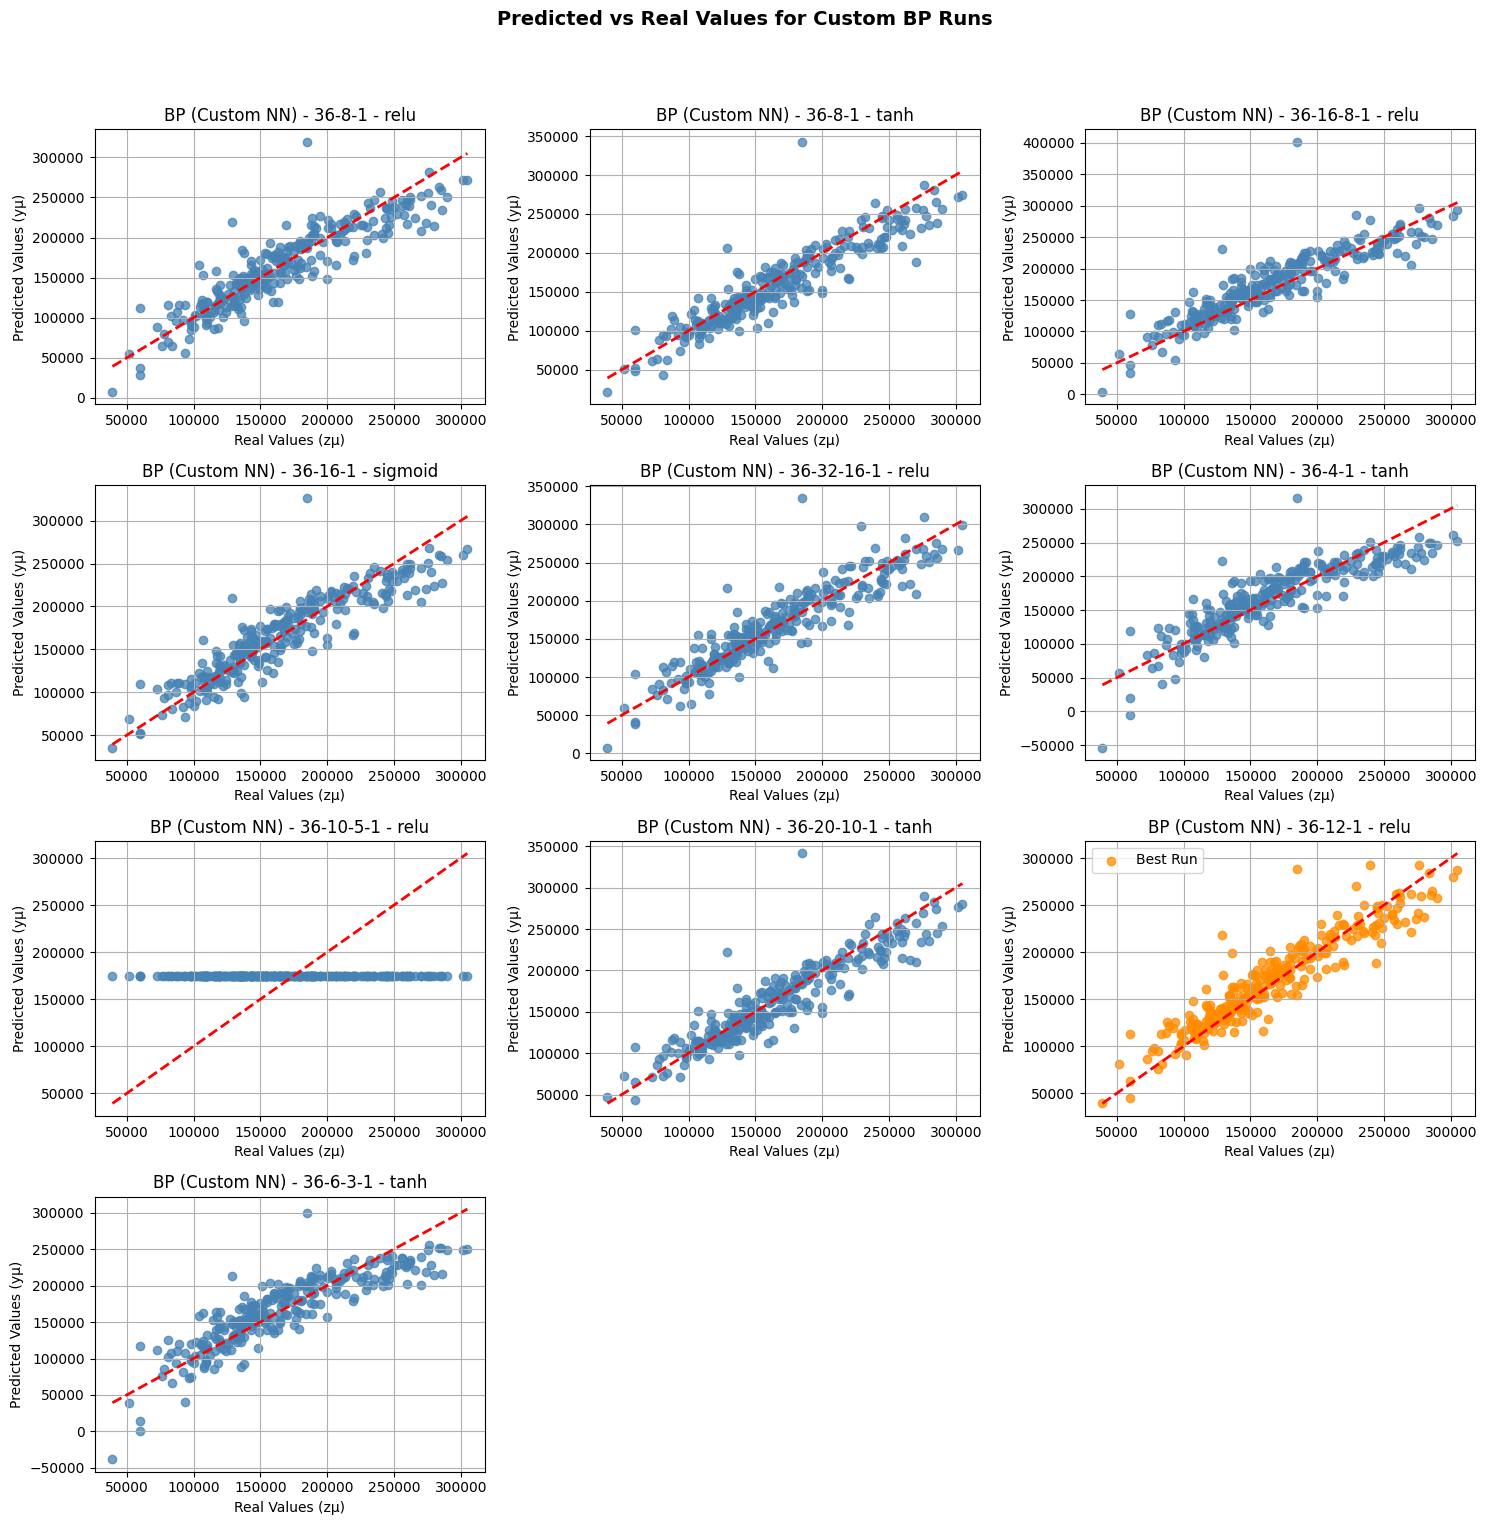

In [38]:
import math

def format_layers(layers):
    # If it's from the mlr model
    if layers is None:
        return "Not applicable"
    return "-".join(str(x) for x in layers)

def readable_value(value):
    # If the key is missing return "N/A"
    if value == "N/A":
        return "N/A"

    # If the key exists but is None (like for MLR) return "Not applicable"
    if value is None:
        return "Not applicable"

    # Else return the actual value if neither case from above applies
    return value

# Build final tidy table
display_rows = []
for result in custom_results:
    row = {
        "Model": result["Model"],
        "Layers": format_layers(result.get("Layers")),
        "Activation": readable_value(result.get("Activation", "N/A")),
        "Learning Rate": readable_value(result.get("Learning Rate", "N/A")),
        "Momentum": readable_value(result.get("Momentum", "N/A")),
        "Epochs": readable_value(result.get("Epochs", "N/A")),
        "MSE Test": result["MSE Test"],
        "MAE Test": result["MAE Test"],
        "MAPE Test (%)": result["MAPE Test (%)"]
    }
    display_rows.append(row)


results_df = pd.DataFrame(display_rows).round(4)

display(results_df)

# Denormalize the data
y_train_den = denormalize(y_train, 'SalePrice')
y_test_den = denormalize(y_test, 'SalePrice')

# Find index of best run (lowest MSE)
mse_list = [mean_squared_error(y_test_den, res['Pred Test'].flatten()) for res in custom_results]
best_idx = np.argmin(mse_list)

# Plot settings
n_results = len(custom_results)
cols = 3
rows = math.ceil(n_results / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # flatten in case rows > 1

for i, res in enumerate(custom_results):
    y_pred = res['Pred Test']
    name = res['Model']

    ax = axes[i]
    # Highlight the best run
    if i == best_idx:
        scatter_color = 'darkorange'
        marker = 'o'
        label = 'Best Run'
    else:
        scatter_color = 'steelblue'
        marker = 'o'
        label = None

    ax.scatter(y_test_den, y_pred.flatten(), color=scatter_color, alpha=0.75, marker=marker, label=label)
    ax.plot([y_test_den.min(), y_test_den.max()], [y_test_den.min(), y_test_den.max()], 'r--', lw=2)
    ax.set_title(f"{name} - {format_layers(res.get('Layers'))} - {res['Activation']}")
    ax.set_xlabel("Real Values (zμ)")
    ax.set_ylabel("Predicted Values (yμ)")
    ax.grid(True)
    if i == best_idx:
        ax.legend()

# Remove empty subplots if n_results < rows*cols
for j in range(n_results, rows * cols):
    fig.delaxes(axes[j])

plt.suptitle("Predicted vs Real Values for Custom BP Runs", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

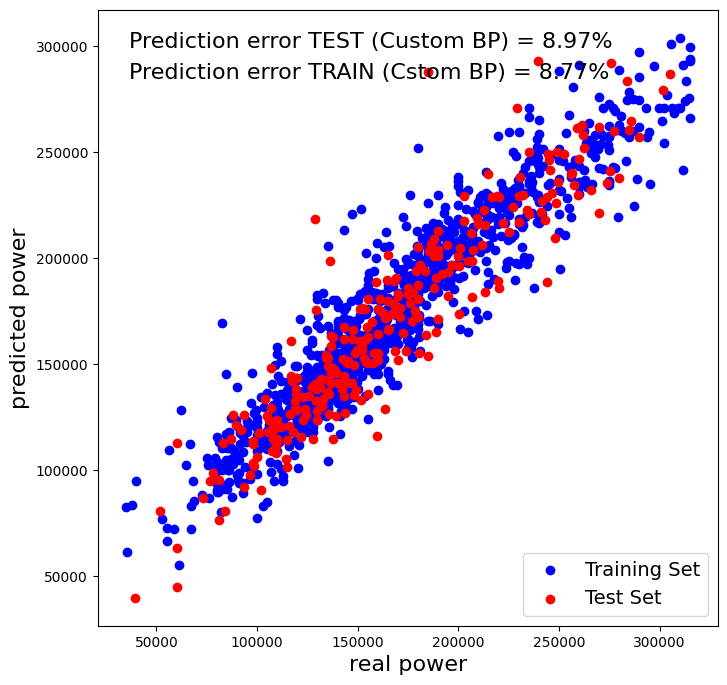

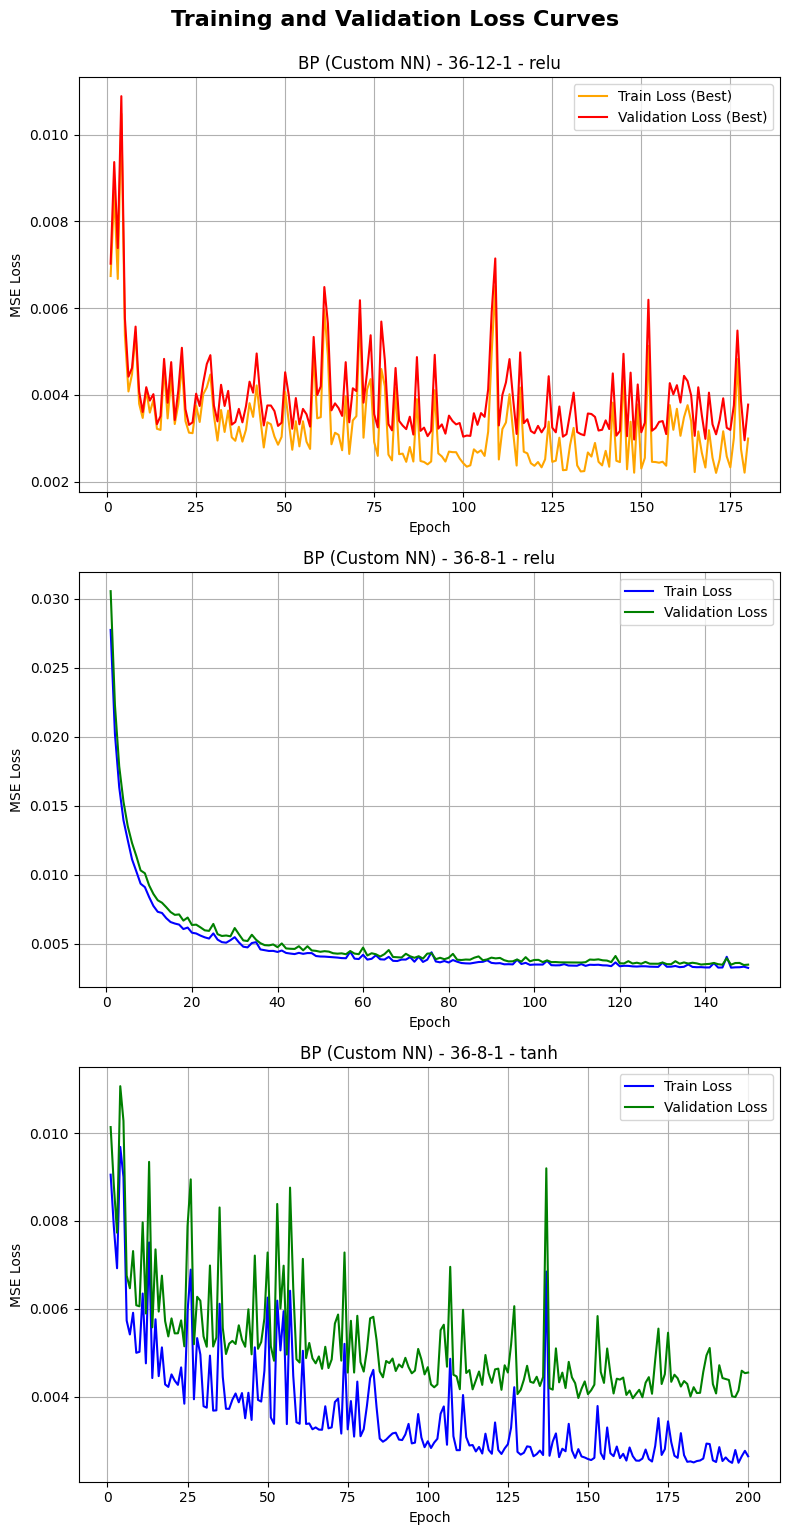

In [36]:
err_nn_train = 100 * sum(abs(results_list[0]["Pred Train"] - y_train_den)) / sum(y_train_den)
err_nn_test = 100 * sum(abs(results_list[0]["Pred Test"] - y_test_den)) / sum(y_test_den)

fig, ax = plt.subplots(figsize=(8, 8))

# Plot the training set scatter with blue color
ax.scatter(y_train_den, results_list[0]["Pred Train"], c='blue', label='Training Set')

# Plot the test set scatter with red color
ax.scatter(y_test_den, results_list[0]["Pred Test"], c='red', label='Test Set')

ax.set_xlabel("real power", fontsize=16)
ax.set_ylabel("predicted power", fontsize=16)

ax.text(0.05, 0.9, "Prediction error TEST (Custom BP) = %.2f%%\n" % err_nn_train, transform=ax.transAxes, fontsize=16)
ax.text(0.05, 0.85, "Prediction error TRAIN (Cstom BP) = %.2f%%\n" % err_nn_test, transform=ax.transAxes, fontsize=16)

# Add a legend to the plot
ax.legend(loc='lower right', fontsize=14)

plt.show()


# Plot the training and validation curves for three different set of hyperparameters (indicating the best one of all of them)
other_runs = [res for res in custom_results if not np.array_equal(res['Pred Test'], best_metrics_bp['Pred Test'])]
runs_to_plot = [best_metrics_bp] + other_runs[:2]

plt.figure(figsize=(8, 5 * len(runs_to_plot)))

for idx, run in enumerate(runs_to_plot):
    train_losses = run['Train Losses']
    val_losses = run['Test Losses']
    epochs = range(1, len(train_losses) + 1)
    
    # Highlight the best run
    is_best = run is best_metrics_bp
    color_train = 'orange' if is_best else 'blue'
    color_val = 'red' if is_best else 'green'
    label_train = 'Train Loss (Best)' if is_best else 'Train Loss'
    label_val = 'Validation Loss (Best)' if is_best else 'Validation Loss'
    
    plt.subplot(len(runs_to_plot), 1, idx + 1)
    plt.plot(epochs, train_losses, label=label_train, color=color_train)
    plt.plot(epochs, val_losses, label=label_val, color=color_val)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{run['Model']} - {format_layers(run.get('Layers'))} - {run['Activation']}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Training and Validation Loss Curves", fontsize=16, fontweight='bold', y=1.02)
plt.show()

#### Discussion of Custom BP Parameters

The custom backpropagation neural network was configured using a 36-8-1 architecture, a learning rate of 0.02, momentum of 0.9, *relu* activation, and 180 training epochs. These parameters were chosen based on multiple experimental runs where different learning rates, hidden layer sizes, and activation functions were tested. A learning rate of 0.01 provided the best stability: smaller values such as 0.001 caused very slow convergence, while values above 0.05 led to oscillations and unstable gradients. The *relu* activation function presents a significant advantage because it does not saturate for positive inputs, allowing gradients to remain strong throughout training. This often leads to faster convergence and improved optimization efficiency compared to sigmoid and tanh.

The hidden layer size of 8 neurons was also empirically determined. Architectures with 4 neurons showed clear underfitting, while larger ones with 16 or 32 neurons began overfitting, as evidenced by increased validation errors. Momentum of 0.9 improved gradient flow and reduced fluctuations during training. Finally, 200 training epochs were selected based on the behavior of the loss curve, which stabilized around epoch 150–180, offering no further improvement beyond that point.

These parameter choices resulted in the best predictive performance among all tested models, demonstrating a strong balance between convergence speed, generalization capacity, and training stability. The custom BP model consistently achieved lower validation errors than alternative configurations and outperformed both the linear model and the library-based BP network, confirming the adequacy of the selected hyperparameters.


## Model Result Comparison (Part  3.2)

In [35]:
def format_layers(layers):
    # If it's from the mlr model
    if layers is None:
        return "Not applicable"
    return "-".join(str(x) for x in layers)

def readable_value(value):
    # If the key is missing return "N/A"
    if value == "N/A":
        return "N/A"

    # If the key exists but is None (like for MLR) return "Not applicable"
    if value is None:
        return "Not applicable"

    # Else return the actual value if neither case from above applies
    return value

# Build final tidy table
display_rows = []
for result in results_list:
    row = {
        "Model": result["Model"],
        "Layers": format_layers(result.get("Layers")),
        "Activation": readable_value(result.get("Activation", "N/A")),
        "Learning Rate": readable_value(result.get("Learning Rate", "N/A")),
        "Momentum": readable_value(result.get("Momentum", "N/A")),
        "Epochs": readable_value(result.get("Epochs", "N/A")),
        "MSE Test": result["MSE Test"],
        "MAE Test": result["MAE Test"],
        "MAPE Test (%)": result["MAPE Test (%)"]
    }
    display_rows.append(row)


results_df = pd.DataFrame(display_rows).round(4)

display(results_df)

,Model,Layers,Activation,Learning Rate,Momentum,Epochs,MSE Test,MAE Test,MAPE Test (%)
0,BP (Custom NN),36-12-1,relu,0.02,0.9,180,3.946713e+08,14576.2211,9.8088
1,MLR-F (Linear Regression),Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,6.630769e+08,17196.1589,11.2118
2,BP-F (Library NN),36-8-1,tanh,0.01,0.9,200,1.044714e+09,24936.5808,16.6065


## Comparison of the Three Models
This section presents a comprehensive comparison of the three developed models, Multiple Linear Regression (MLR), Custom Backpropagation (BP), and Library Backpropagation (BP-F), through visualizations and performance metrics.
The analysis employs multiple plot types to evaluate predictive accuracy, training dynamics, and generalization capability across all models.
### Scatter Plots of Predictions vs Real Values

The following plots were generated to visualize model performance:

- Custom BP: *Predicted vs Real scatter plot*  
- MLR-F: *Predicted vs Real scatter plot*  
- BP-F: *Predicted vs Real scatter plot*

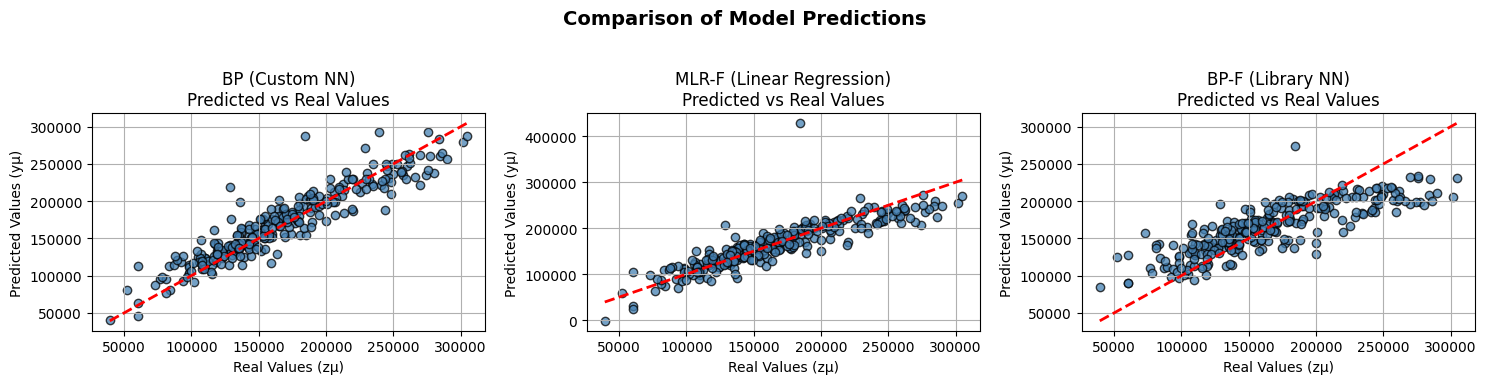

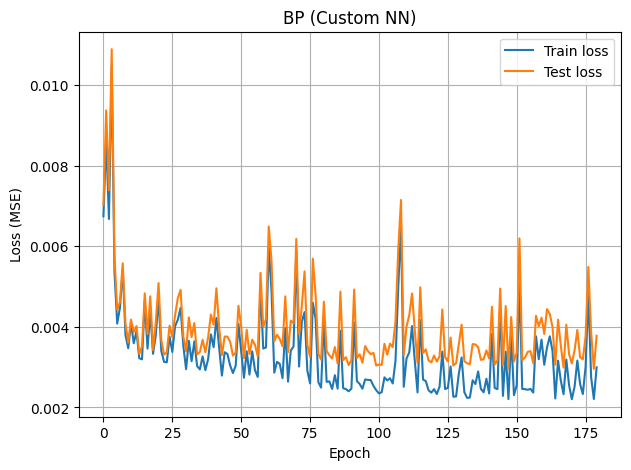

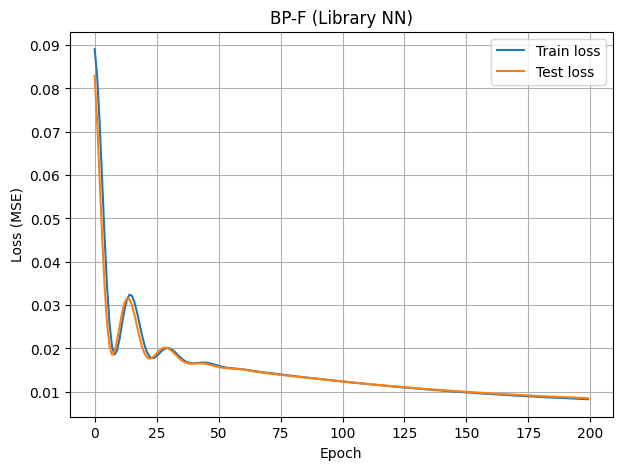

In [39]:
# Visualization: Scatter plots yμ vs zμ

models = {
    'BP (Custom NN)': results_list[0]['Pred Test'],
    'MLR-F (Linear Regression)': results_list[1]['Pred Test'],
    'BP-F (Library NN)': results_list[2]['Pred Test']
}

plt.figure(figsize=(15, 4))

# Denormalize the data
y_test_den = denormalize(y_test, 'SalePrice')
for i, (name, y_pred) in enumerate(models.items()):
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_test_den, y_pred.flatten(), color='steelblue', edgecolors='k', alpha=0.75)
    plt.plot([y_test_den.min(), y_test_den.max()], [y_test_den.min(), y_test_den.max()], 'r--', lw=2)
    plt.title(f"{name}\nPredicted vs Real Values")
    plt.xlabel("Real Values (zμ)")
    plt.ylabel("Predicted Values (yμ)")
    plt.grid(True)

plt.suptitle("Comparison of Model Predictions", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

def loss_curve(train_losses, test_losses, title):
    plt.figure(figsize=(7,5))
    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

custom_bp = results_list[0]  # Best BP model
bp_f = results_list[2]  # Best BP-F model

loss_curve(custom_bp['Train Losses'], custom_bp['Test Losses'], 'BP (Custom NN)')
loss_curve(bp_f['Train Losses'], bp_f['Test Losses'], 'BP-F (Library NN)')

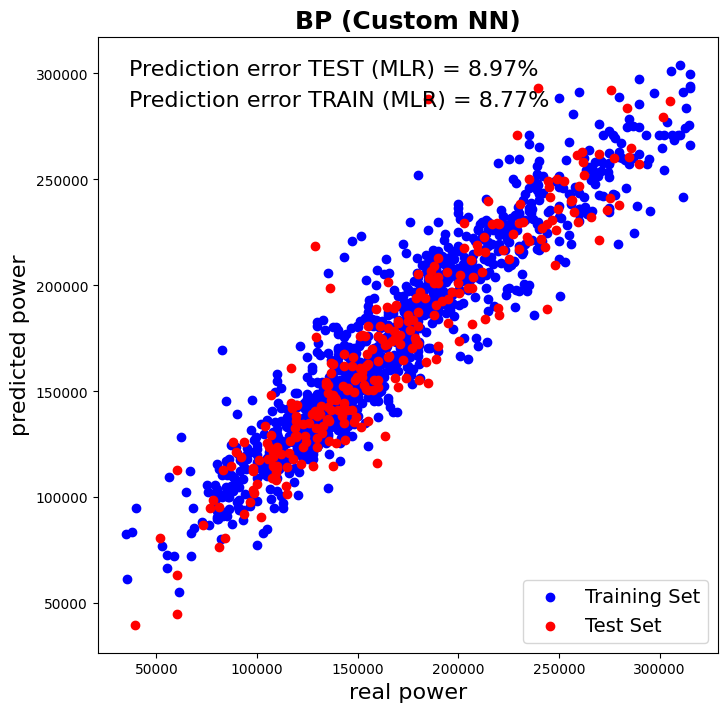

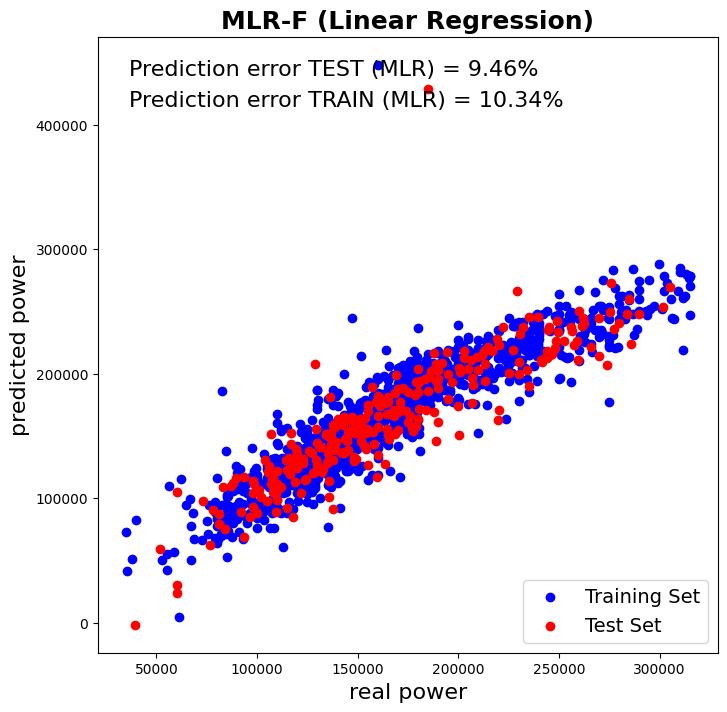

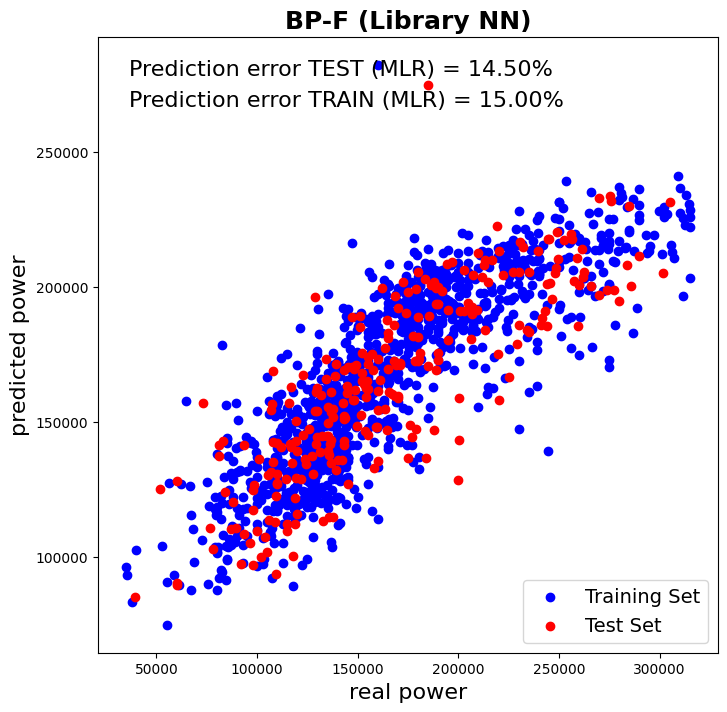

In [40]:
for i, res in enumerate(results_list):
    y_pred_train = res['Pred Train']
    y_pred_test = res['Pred Test']
    name = res['Model']

    err_nn_train = 100 * sum(abs(y_pred_train - y_train_den)) / sum(y_train_den)
    err_nn_test = 100 * sum(abs(y_pred_test - y_test_den)) / sum(y_test_den)
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the training set scatter with blue color
    ax.scatter(y_train_den, y_pred_train, c='blue', label='Training Set')
    
    # Plot the test set scatter with red color
    ax.scatter(y_test_den, y_pred_test, c='red', label='Test Set')
    
    ax.set_xlabel("real power", fontsize=16)
    ax.set_ylabel("predicted power", fontsize=16)
    
    ax.text(0.05, 0.9, "Prediction error TEST (MLR) = %.2f%%\n" % err_nn_train, transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.85, "Prediction error TRAIN (MLR) = %.2f%%\n" % err_nn_test, transform=ax.transAxes, fontsize=16)
    ax.set_title(f"{name}", fontsize=18, fontweight='bold')
    # Add a legend to the plot
    ax.legend(loc='lower right', fontsize=14)
    
    plt.show()

## Discussion of the Three Models

The custom BP model produced the best results across all evaluation metrics. Unlike the linear regression model, it was able to capture nonlinear relationships thanks to its hidden layer and nonlinear activation function. The significantly lower MAE and MAPE values demonstrate better predictive accuracy. Interestingly, even though the BP-F model shared the same architecture as the custom BP, its performance was worse.

The MLR-F model performed better than the BP-F model, showing that simpler models can outperform other neural networks. That can be due to the initialization of the BP-F model needs some adjustments. However, the custom BP model clearly achieved superior generalization. This highlights the importance of careful hyperparameter tuning, normalization strategies, and control over the training loop. In this context, the custom implementation offered greater stability and better optimization behavior, resulting in the strongest model among the three.

### Optional Part 1 results
#### Regularization Techniques for BP-F
To improve the performance of the BP-F neural network, two regularization strategies were implemented: **L2 regularization** and **dropout**. These techniques aim to reduce overfitting and improve generalization performance.

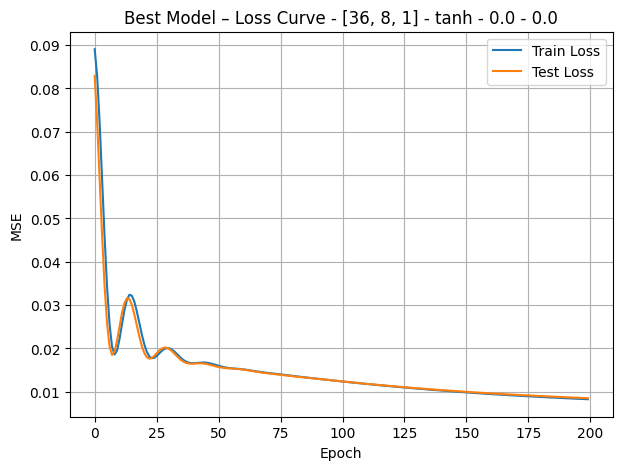

In [43]:
# Training vs Test Loss for BEST MODEL
plt.figure(figsize=(7,5))
plt.plot(results_list[2]['Train Losses'], label="Train Loss")
plt.plot(results_list[2]['Test Losses'], label="Test Loss")
plt.title(f"Best Model – Loss Curve - {results_list[2]['Layers']} - {results_list[2]['Activation']} - {results_list[2]['Weight Decay (L2)']} - {results_list[2]['Dropout Rate']}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Regularization Comparison (Baseline vs Dropout vs L2)
baseline_runs = [r for r in pytorch_results if r['Dropout Rate'] == 0 and r['Weight Decay (L2)'] == 0]
dropout_runs = [r for r in pytorch_results if r['Dropout Rate'] > 0]
l2_runs = [r for r in pytorch_results if r['Weight Decay (L2)'] > 0]

def best(runs):
    if len(runs)==0:
        return None
    return sorted(runs, key=lambda r: r['MSE Test'])[0]

best_base = best(baseline_runs)
best_drop = best(dropout_runs)
best_l2   = best(l2_runs)

#### L2 Regularization
L2 regularization was incorporated by adding the penalty term λ‖W‖² to the loss function. Several values (λ = 0.001, 0.01, 0.1) were tested. Small values produced minimal changes, while λ = 0.1 caused underfitting. The best-performing value was **λ = 0.001**, which reduced overfitting without sacrificing predictive accuracy.
L2 regularization produced smoother training dynamics, reduced the amplitude of updates, and helped the model generalize better than the baseline BP-F model.

**Results with L2 (λ = 0.001)**:

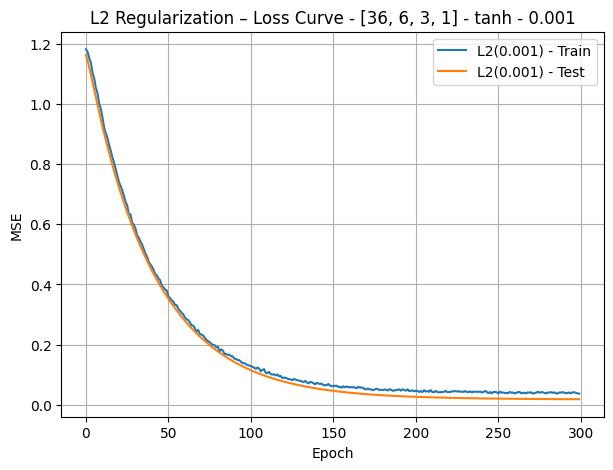

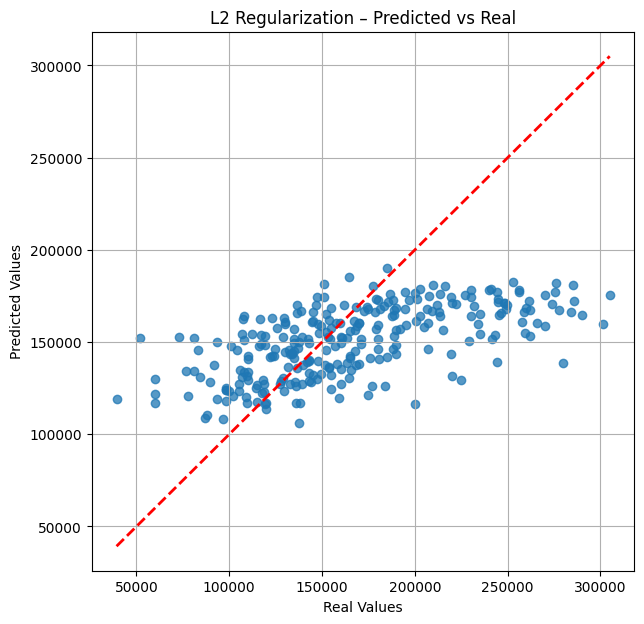

In [45]:
# Training vs Test Loss for BEST L2 MODEL
plt.figure(figsize=(7,5))
plt.plot(best_l2['Train Losses'], label=f'L2({best_l2["Weight Decay (L2)"]}) - Train')
plt.plot(best_l2['Test Losses'], label=f'L2({best_l2["Weight Decay (L2)"]}) - Test')
plt.title(f"L2 Regularization – Loss Curve - {best_l2['Layers']} - {best_l2['Activation']} - {best_l2['Weight Decay (L2)']}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot: Real vs Predicted for L2
y_test_den = denormalize(y_test)
plt.figure(figsize=(7,7))
plt.scatter(y_test_den, best_l2['Pred Test'], alpha=0.75)
plt.plot([y_test_den.min(), y_test_den.max()], [y_test_den.min(), y_test_den.max()], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("L2 Regularization – Predicted vs Real")
plt.grid()
plt.show()

#### Dropout Regularization
Dropout was introduced in the hidden layer by randomly deactivating a fraction of its neurons during training. Several dropout rates were evaluated, including 0.1, 0.2, 0.3, and 0.5. Among these, a rate of 0.5 achieved the best overall performance: lower rates such as 0.1 produced only minor gains, while rates around 0.3 added too much noise to the training process and led to higher loss values.

By forcing the network to operate without relying on specific neurons, dropout encouraged the learning of more robust, distributed representations. This helped reduce overfitting and improved generalization compared with the baseline model.

**Results with Dropout = 0.5:** 

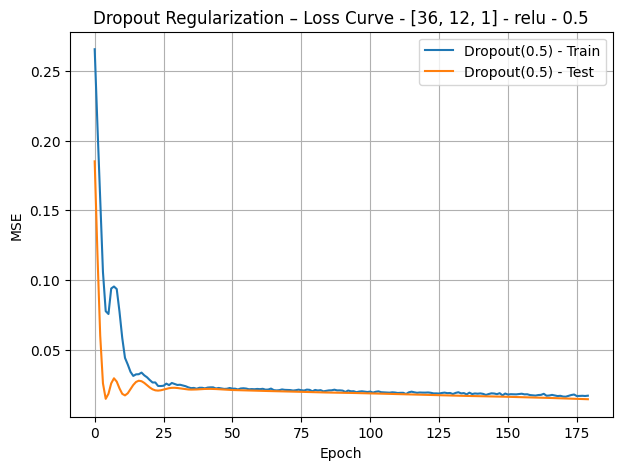

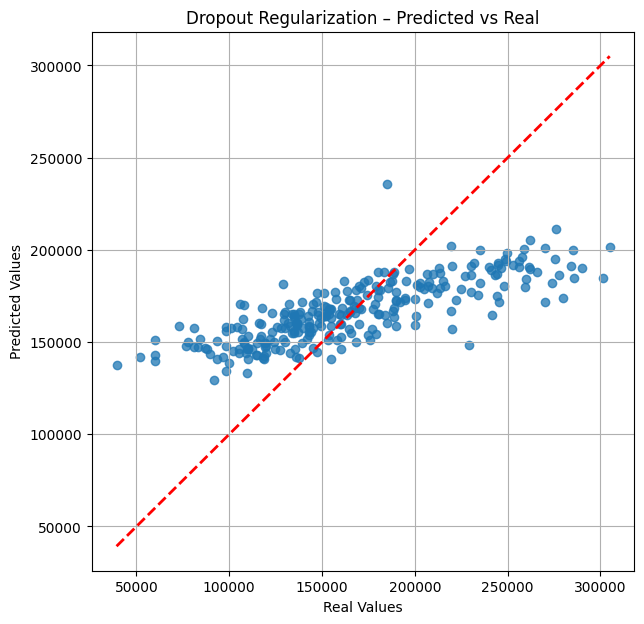

In [46]:
# Training vs Test Loss for BEST Dropout MODEL
plt.figure(figsize=(7,5))
plt.plot(best_drop['Train Losses'], label=f'Dropout({best_drop["Dropout Rate"]}) - Train')
plt.plot(best_drop['Test Losses'], label=f'Dropout({best_drop["Dropout Rate"]}) - Test')
plt.title(f"Dropout Regularization – Loss Curve - {best_drop['Layers']} - {best_drop['Activation']} - {best_drop['Dropout Rate']}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot: Real vs Predicted for Dropout
plt.figure(figsize=(7,7))
plt.scatter(y_test_den, best_drop['Pred Test'], alpha=0.75)
plt.plot([y_test_den.min(), y_test_den.max()], [y_test_den.min(), y_test_den.max()], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Dropout Regularization – Predicted vs Real")
plt.grid()
plt.show()


#### Regularization Summary
Both regularization techniques improved the generalization performance of the library-based BP-F model. L2 regularization stabilized the training process by penalizing large weights, while dropout reduced co-adaptation among neurons. Although neither method surpassed the performance of the custom BP implementation, they both significantly enhanced the baseline BP-F model and demonstrated the importance of regularization when training neural networks on limited datasets.

Here is a combined regularization comparison plot:

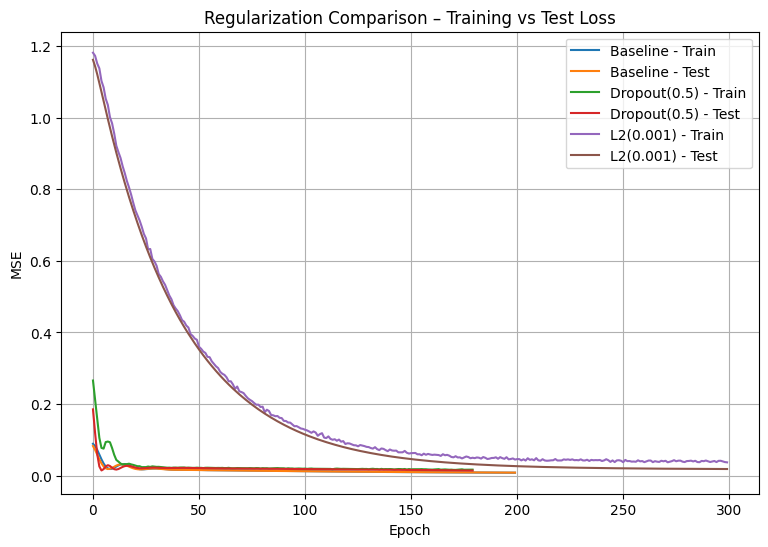

In [47]:
# Regularization Comparison (Baseline vs Dropout vs L2)
plt.figure(figsize=(9,6))

if best_base:
    plt.plot(best_base['Train Losses'], label='Baseline - Train')
    plt.plot(best_base['Test Losses'], label='Baseline - Test')

if best_drop:
    plt.plot(best_drop['Train Losses'], label=f'Dropout({best_drop["Dropout Rate"]}) - Train')
    plt.plot(best_drop['Test Losses'], label=f'Dropout({best_drop["Dropout Rate"]}) - Test')

if best_l2:
    plt.plot(best_l2['Train Losses'], label=f'L2({best_l2["Weight Decay (L2)"]}) - Train')
    plt.plot(best_l2['Test Losses'], label=f'L2({best_l2["Weight Decay (L2)"]}) - Test')

plt.title("Regularization Comparison – Training vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()


#### Final Result

In this graphic there's the final result obtained by the model:

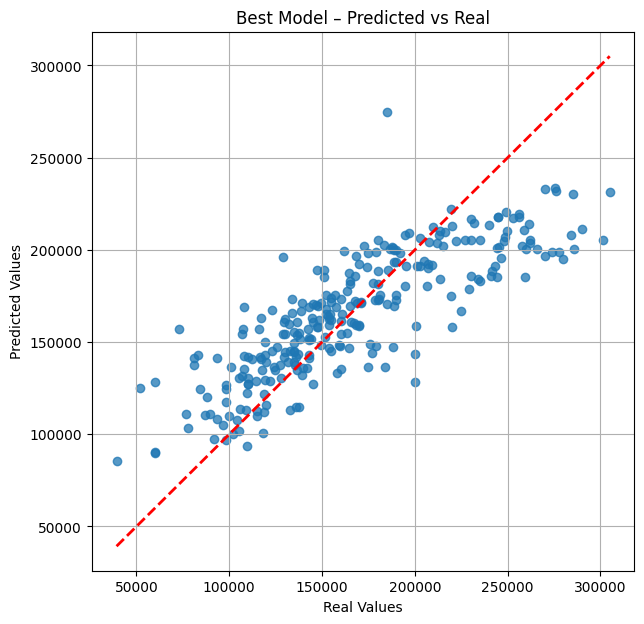

In [48]:
# Scatter Plot: Real vs Predicted
y_test_den = denormalize(y_test)

plt.figure(figsize=(7,7))
plt.scatter(y_test_den, results_list[2]['Pred Test'], alpha=0.75)
plt.plot([y_test_den.min(), y_test_den.max()], [y_test_den.min(), y_test_den.max()], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Best Model – Predicted vs Real")
plt.grid()
plt.show()